
## Project: Fraud Dectection

## Introduction

The PwC global economic crime survey of 2016 suggests that approximately 36% of organizations experienced economic crime. Therefore, there is definitely a need to solve the problem of credit card fraud detection. The task of fraud detection often boils down to outlier detection, in which a dataset is scanned through to find potential anomalies in the data. In the past, this was done by employees  which checked all transactions manually. With the rise of machine learning, artificial intelligence, deep learning and other relevant fields of information technology, it becomes feasible to automate this process and to save some of the intensive amount of labor that is put into detecting credit card fraud. 

In this project, I will be training a model with pandas, seaborn and scikit-learn to create a fraud detection classifier.

The dataset for this project originates from the Kaggle https://www.kaggle.com/c/ieee-fraud-detection/data


----
## Importing the Data 


In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the credit card dataset
data = pd.read_csv("creditcard.csv")

----
## Exploring the Data 

The data consists of 28 variables. We do not know the exact meanings of the variables (due to privacy concerns). The Class field indicates instances of fraud (0 representing non fraudulent transactions and  1 representing a fraudulent transaction).   


In [2]:
display(data.head(n=1))

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0


In [4]:
#Total number of records
n_records = data.shape[0]

#Number of non fraudulent transactions
no_fraud = data[data["Class"] == 0].shape[0]

#Number of fraudulent transactions
fraud = data[data["Class"] == 1].shape[0]

#Percentage of fraud cases 
fraud_percent = (fraud)*100/n_records

# Print the results
print("Total number of records: {}".format(n_records))
print("Number of non fraudulent transactions: {}".format(no_fraud))
print("Number of fraudulent transactions: {}".format(fraud))
print("Percentage of fraud transactions: {}%".format(fraud_percent))

Total number of records: 284807
Number of non fraudulent transactions: 284315
Number of fraudulent transactions: 492
Percentage of fraud transactions: 0.1727485630620034%


** Initial Observations **

From the counts above we can observe that we are dealing with highly imbalanced data and as such our measure of performance has to extend beyond accuracy as the predications of the majority class will dominate and produce a high accuracy. If we were to use a "dumb" classifier where we selected all cases as no fraud, we would receive good accuracy as well. Precision and recall are better measures for this task. 

The business requirements are:

If fraud is detected when a transaction occurs the transaction should be stopped and the card should be blocked
The model needs to be precise enough so as to not block legitimate transactions
The model should provide the probability estimate of a transaction being fraudulent

Converting business problem to machine learning problem

Since the task involves predicting fraud or no fraud, this is a binary classification problem.
Performance metric used in this case study is area under the ROC curve. 
The model should give probabilistic output.
Low latency (no delay)
Minimize false positives and false negatives. 



----
## Preparing the Data


In [36]:
## We first need to remove missing data from our dataset
data.dropna(inplace=True) #remve all rows where 'NaN' exists


In [37]:
#Checking skewness along the index axis 
data.skew(axis = 0, skipna = True)

Time      -0.035568
V1        -3.280667
V2        -4.624866
V3        -2.240155
V4         0.676292
V5        -2.425901
V6         1.826581
V7         2.553907
V8        -8.521944
V9         0.554680
V10        1.187141
V11        0.356506
V12       -2.278401
V13        0.065233
V14       -1.995176
V15       -0.308423
V16       -1.100966
V17       -3.844914
V18       -0.259880
V19        0.109192
V20       -2.037155
V21        3.592991
V22       -0.213258
V23       -5.875140
V24       -0.552499
V25       -0.415793
V26        0.576693
V27       -1.170209
V28       11.192091
Amount    16.977724
Class     23.997579
dtype: float64

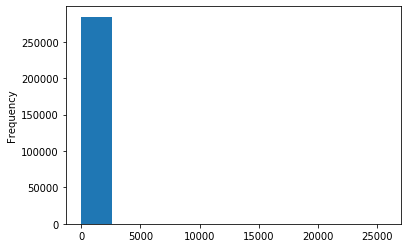

In [17]:
#Creating a histogram of the amount column

data["Amount"].plot.hist()

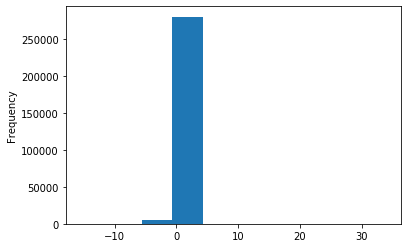

In [16]:
#Creating a histogram of the V28 column

data["V28"].plot.hist()

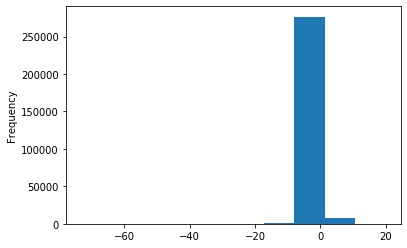

In [18]:
#Creating a histogram of the V8 column

data["V8"].plot.hist()

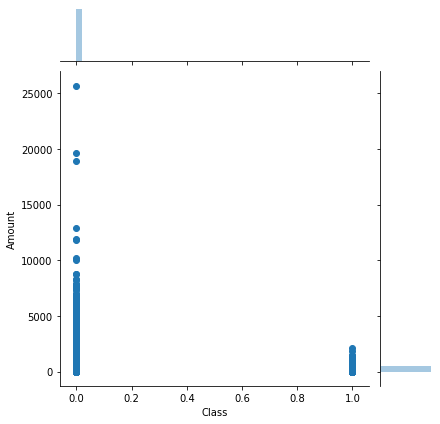

In [14]:
import seaborn as sns

sns.jointplot(x="Class",y="Amount",data=data)

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the credit card dataset three features fit this description: `'Amount'` `'V8'`  and `'V28'`. 

For highly-skewed feature distributions such as `'Amount'` `'V8'`  and `'V28'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.



In [38]:
# Split the data into features and target label
class_raw = data['Class']
features_raw = data.drop('Class', axis = 1)

In [39]:
# Log-transform the Amount feature since V8 and V28 contain negative values 
skewed = ['Amount']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Normalization ensures that each feature is treated equally when applying supervised learners. 

In [40]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['Amount']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 1))

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.493873


### One-hot encoding

Since all our features are numeric one-hot encoding is not necessary and such we move on to the next step.

In [41]:
features_final = features_log_minmax_transform

### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

Run the code cell below to perform this split.

In [42]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    class_raw, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 227845 samples.
Testing set has 56962 samples.


----
## Evaluating Model Performance

We will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor

We will consider the **F-beta score** (weighted average(harmonic mean) of the precision and recall scores) as a metric that considers both precision and recall but pay closer attention to recall when selecting our best model since there is a high cost associated with false Negatives.

Looking at the distribution of classes we observed above the huge imbalance. Snce we could simply say every transaction is not fraud and generally be right, without ever looking at the data, this would be our **naive** prediction, since we have not considered any information to substantiate the claim. This will be the benchmark for whether a model is performing well. 


#### accuracy, precision, recall

** Accuracy ** measures how often the classifier makes the correct prediction. It’s the ratio of the number of correct predictions to the total number of predictions (the number of test data points).

** Precision ** tells us what proportion of messages we classified as spam, actually were spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all positives(all words classified as spam, irrespective of whether that was the correct classificatio), in other words it is the ratio of

`[True Positives/(True Positives + False Positives)]`

** Recall(sensitivity)** tells us what proportion of messages that actually were spam were classified by us as spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all the words that were actually spam, in other words it is the ratio of

`[True Positives/(True Positives + False Negatives)]`



In [44]:
#Calculate accuracy, precision and recall

accuracy = fraud / n_records
recall = fraud / (fraud + 0)
precision = fraud / (fraud + no_fraud)

#Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
fscore = (1  + (0.5*0.5)) * ( precision * recall / (( 0.5*0.5 * (precision))+ recall))

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.0017, F-score: 0.0022]


### Implementation - Creating a Training and Predicting Pipeline


In [45]:
from sklearn.metrics import fbeta_score, accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size],y_train[:sample_size])
    end = time() # Get end time
    
    #Calculate the training time
    results['train_time'] = end-start
        
    # Get the predictions on the test set(X_test),
    # then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    #Calculate the total prediction time
    results['pred_time'] = end-start
            
    #Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300],predictions_train)
        
    #Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test,predictions_test)
    
    #Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:300],predictions_train,beta=0.5)
        
    #Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test,predictions_test,beta=0.5)
       
    #Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

### Initial Model Evaluation

- We will Import the three supervised learning models
- Then initialize the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
- Then calculate the number of records equal to 1%, 10%, and 100% of the training data.
- Values will be stored in  `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.


C:\Users\s5831539\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\s5831539\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\s5831539\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\s5831539\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression trained on 2278 samples.


C:\Users\s5831539\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\s5831539\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\s5831539\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression trained on 22784 samples.


C:\Users\s5831539\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\s5831539\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\s5831539\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\s5831539\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


LogisticRegression trained on 227845 samples.
DecisionTreeClassifier trained on 2278 samples.


C:\Users\s5831539\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\s5831539\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


DecisionTreeClassifier trained on 22784 samples.


C:\Users\s5831539\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\s5831539\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\s5831539\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


DecisionTreeClassifier trained on 227845 samples.
GradientBoostingClassifier trained on 2278 samples.


C:\Users\s5831539\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\s5831539\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\s5831539\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


GradientBoostingClassifier trained on 22784 samples.


C:\Users\s5831539\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\s5831539\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


GradientBoostingClassifier trained on 227845 samples.


C:\Users\s5831539\Documents\Fraud Detection\visuals.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  pl.tight_layout()


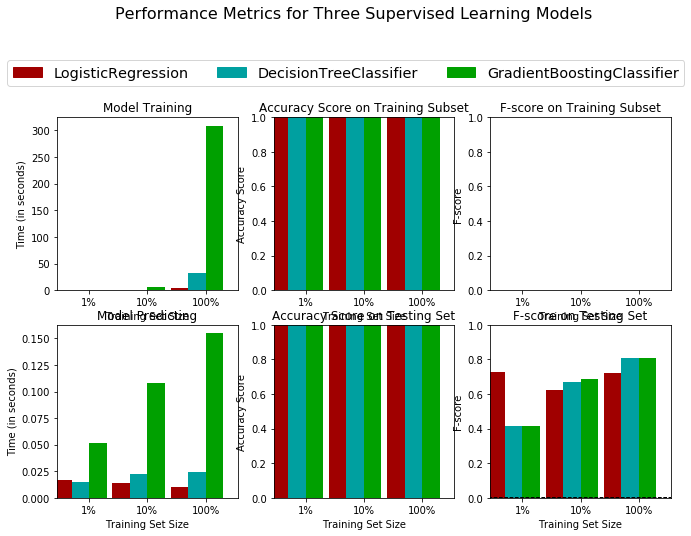

In [49]:
#Import the three supervised learning models from sklearn
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier


#Initialize the three models
clf_A = LogisticRegression(random_state=42)
clf_B = DecisionTreeClassifier(random_state=42)
clf_C = GradientBoostingClassifier(random_state=42)

#Calculate the number of samples for 1%, 10%, and 100% of the training data

samples_100 = len(X_train)
samples_10 = int(round(len(X_train) / 10))
samples_1 = int(round(len(X_train) / 100))

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

----
## Improving Results
We will now choose from the three supervised learning models the *best* model to use on our data by perfomring a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

**Considerations **

Of the three supervised learning models, The logistic regression slassifier appears to be most appropriate for the task at hand because it performs reasonably well on the testing data (for all three dataset sizes), in terms of f-score while having a low prediction and training time even when 100% of the training data is used.This therefore means that it should scale well even if we have a larger dataset and also required when quickly identifying fraud. 


### Implementation: Model Tuning
We will now fine tune the logistic regression model using grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. We will need to use the entire training set for this task. 

Our proceedure is as follows; 

- Initialize the classifier and store it in `clf`.
- Create a dictionary of parameters you wish to tune for the chosen model.
- Use `make_scorer` to create an `fbeta_score` scoring object
- Perform grid search on the classifier `clf` using the `'scorer'`, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.


In [51]:
#Import 'GridSearchCV', 'make_scorer', and any other necessary libraries

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer


#Initialize the classifier
clf =  LogisticRegression(random_state=42)

#Create the parameters list to tune

parameters = {'penalty': ['l1', 'l2'],
              'C': np.logspace(0, 4, 10),              
             }


#Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score,beta=0.5)


#Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters,scorer)


#Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train,y_train)

#Get the estimator
best_clf = grid_fit.best_estimator_

#Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

C:\Users\s5831539\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\s5831539\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\s5831539\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\s5831539\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\s5831539\App

C:\Users\s5831539\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\s5831539\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\s5831539\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\s5831539\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\s5831539\AppData\Local\Continuum\anaconda3\lib\site-package

Unoptimized model
------
Accuracy score on testing data: 0.9990
F-score on testing data: 0.7226

Optimized Model
------
Final accuracy score on the testing data: 0.9992
Final F-score on the testing data: 0.8226


In [54]:
best_parameters =  grid_obj.best_params_  
print(best_parameters) 

{'C': 7.742636826811269, 'penalty': 'l1'}


In [52]:
from sklearn.metrics import precision_score,recall_score,accuracy_score,f1_score,confusion_matrix,classification_report

In [53]:
clf =LogisticRegression(random_state=42)

clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
print(accuracy_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

C:\Users\s5831539\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.9989642217618764
[[56841    20]
 [   39    62]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56861
           1       0.76      0.61      0.68       101

    accuracy                           1.00     56962
   macro avg       0.88      0.81      0.84     56962
weighted avg       1.00      1.00      1.00     56962



In [56]:
clf =LogisticRegression(C=7.742636826811269, penalty='l1', random_state=42)

clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
print(accuracy_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

C:\Users\s5831539\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.9992099996488887
[[56853     8]
 [   37    64]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56861
           1       0.89      0.63      0.74       101

    accuracy                           1.00     56962
   macro avg       0.94      0.82      0.87     56962
weighted avg       1.00      1.00      1.00     56962



### Final Model Evaluation

* From the confusion matrix above we note the false positives are low (8) relative to true positives which is preferred given our business requirements  

* Now we wll look at our optimized model's accuracy and F-score on the testing data comparing it with both the unoptimized model and the naive predictor benchmarks  


#### Results:

|     Metric     | Unoptimized Model | Optimized Model |
| :------------: | :---------------: | :-------------: | 
| Accuracy Score |      0.9989       |   0.9992        |
| F-score        |      0.6800       |   0.7400        |


The otimized model's F-Score is 0.74. This scores are slightly better than the unoptimized model however the results from the optimized model are way better than the naive predictor benchmarks and thus justifies building/using the model. 

----
## ROC Curve

AUC - ROC curve is a performance measurement for classification problem at various thresholds settings. ROC is a probability curve and AUC represents degree or measure of separability. It tells how much model is capable of distinguishing between classes. Higher the AUC, better the model is at predicting 0s as 0s and 1s as 1s. By analogy, Higher the AUC, better the model is at distinguishing between fraudulent transactions and non fraudulent ones

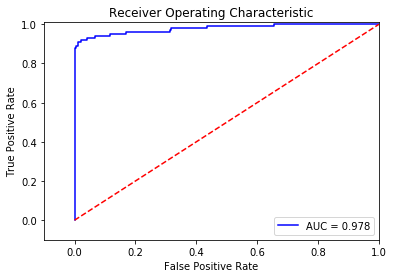

In [60]:
from sklearn.metrics import auc, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

y_pred_sample_score = clf.predict_proba(X_test)


fpr, tpr, thresholds = roc_curve(y_test, y_pred_sample_score[:,1])

roc_auc = auc(fpr,tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.3f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [61]:
!!jupyter nbconvert *.ipynb

['[NbConvertApp] Converting notebook fraud_detection.ipynb to html',
 '[NbConvertApp] Writing 476165 bytes to fraud_detection.html']